# <center>Glow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_moons import *
from utils.training_mnist import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**Invertible 1x1 Convolution:** 
LU Decomposition: $W=PL(U+\mathrm{diag}(s))$
where P is a fixed permutation matrix, L is a lower triangular matrix with 1 on the diagonal, U is a upper triangular matrix with 0 on the diagonal and s is a vector.
In practice, we first sample W as a rotation matrix and we compute the corresponding P, L, U and s.

**Act Norm:**
\begin{equation*}
    z' = s\odot z+b
\end{equation*}
$s$ and $b$ are initialized such that they have 0 mean and unit variance after an initial minibatch of data.

## Moons

In [ ]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(ActNorm(dim=d))
    flows.append(LUInvertible(dim=d))
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126800


0 1.9512600898742676


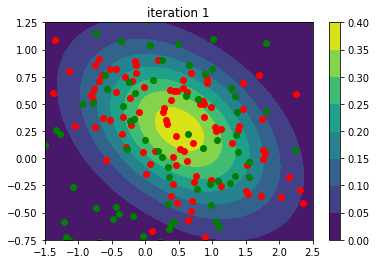

1000 1.3572633266448975


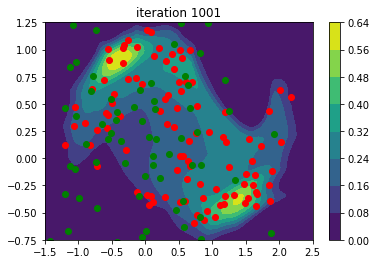

2000 1.261560320854187


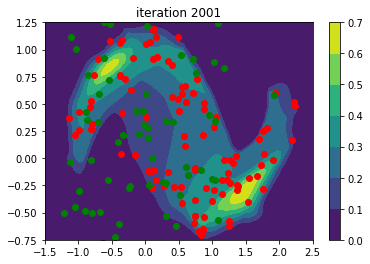

3000 1.300847053527832


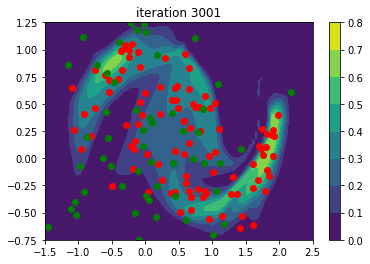

4000 1.2714309692382812


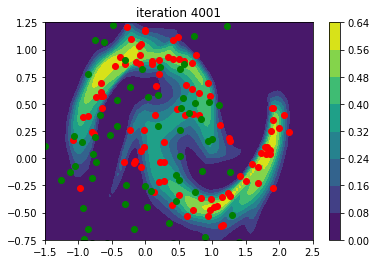

5000 1.2356250286102295


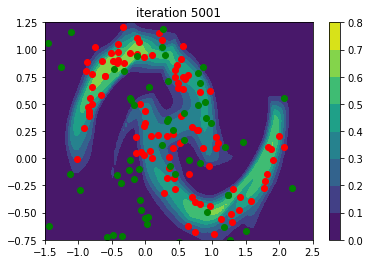

6000 1.2178341150283813


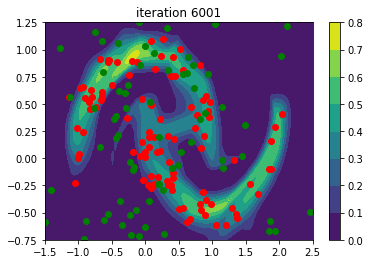

7000 1.177222728729248


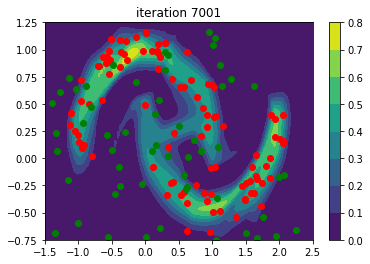

8000 1.0752365589141846


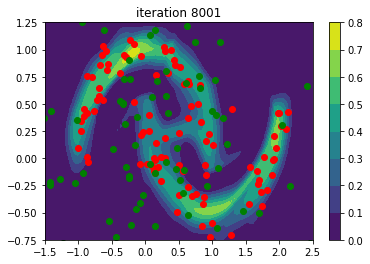

9000 1.1060264110565186


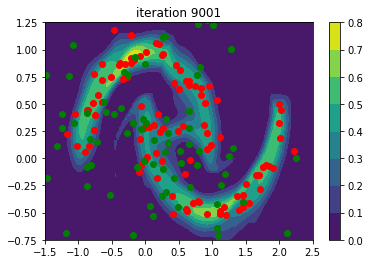

10000 1.0381639003753662


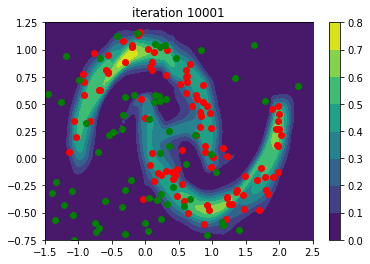

In [ ]:
train_loss = train_moons(model, optimizer, base_distr="normal")

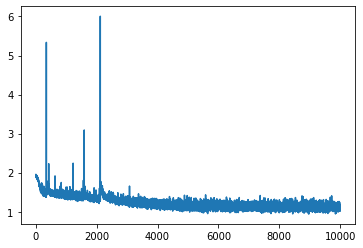

In [ ]:
plt.plot(train_loss)
plt.show()

## MNIST

In [4]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


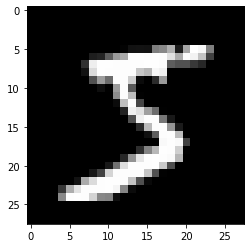

In [6]:
plt.imshow(inverse_logit(train_dataset[0][0]).reshape(28,28),"gray")
plt.show()

In [7]:
d = 784

shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(ActNorm(dim=d))
    flows.append(LUInvertible(dim=d))
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    
model = NormalizingFlows(flows).to(device)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  24696640


0 1465.5398071549341


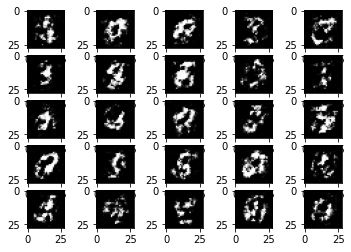

50 1310.6295819313034


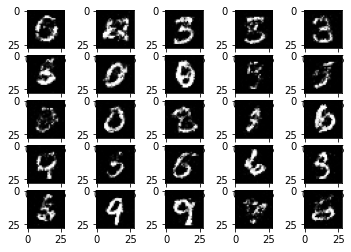

100 1270.2956865713286


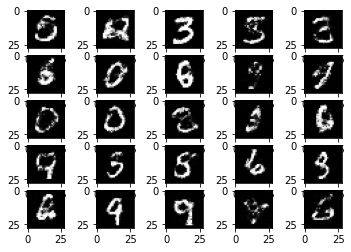

In [9]:
train_losses = train_mnist(model, optimizer, train_loader)

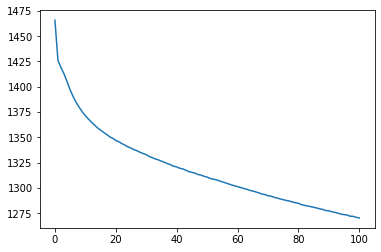

In [10]:
plt.plot(train_losses)
plt.show()

In [22]:
test_batch = []

base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(d,device=device),torch.eye(d,device=device))

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det, base_distr)

    test_batch.append(l.mean().item())

In [23]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = -log_likelihood / (np.prod(784) * np.log(2.))
print(bpd)

2.353711987044285


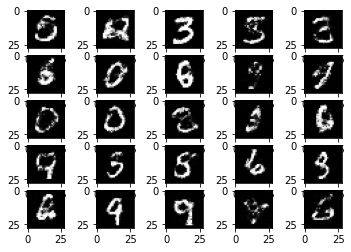

In [24]:
val_mnist(model, device)

## References

<a id="reference1"></a>

[1] Kingma, D. & Dhariwal, P. Glow: Generative flow with invertible 1x1 convolutions. arXiv preprint arXiv:1807.03039. (2018). [link](https://arxiv.org/pdf/1807.03039)